In [3]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sqlalchemy import create_engine
from scipy.stats import zscore
import matplotlib.pyplot as plt
import joblib
import logging
logging.basicConfig(level=logging.INFO)


In [ ]:
class SalesPerformancePrediction:
    def __init__(self):
        self.label_encoders = {}
        self.models = {}
        self.scaler = StandardScaler()

    def fetch_data_from_sql(self, query, server, database):
        """
        Fetch data from SQL Server using SQLAlchemy
        """
        logging.info("Fetching data from SQL Server...")
        engine = create_engine(f"mssql+pyodbc://{server}/{database}?driver=ODBC+Driver+17+for+SQL+Server")
        data = pd.read_sql_query(query, engine)
        return data

    def prepare_data(self, fact_sales, dim_product, dim_date, dim_territory):
        """
        Merge dimension tables with fact_sales and calculate metrics
        """
        logging.info("Merging dimension tables with fact_sales...")
        sales_data = fact_sales.merge(dim_product, on='ProductKey')\
                            .merge(dim_date, on='DateKey')\
                            .merge(dim_territory, on='TerritoryKey')

        # Calculate target metrics
        logging.info("Calculating target metrics...")
        sales_data['Revenue'] = sales_data['OrderQty'] * sales_data['UnitPrice']
        sales_data['GrossProfit'] = sales_data['Revenue'] - (sales_data['OrderQty'] * sales_data['StandardCost'])
        sales_data['GrossMargin'] = sales_data['GrossProfit'] / sales_data['Revenue']
        sales_data['AOV'] = sales_data['Revenue'] / sales_data.groupby('SalesKey')['OrderQty'].transform('sum')
        sales_data['YoYGrowth'] = sales_data.groupby('Year')['Revenue'].pct_change(periods=1).fillna(0)
        
        # sales_data['YoYGrowth'] = sales_data.groupby(['Category'])['Revenue'].transform(
        #     lambda x: x.pct_change(periods=12, fill_method=None)
        # ).fillna(0)

        # Add lag features and rolling statistics
        # logging.info("Adding lag features and rolling statistics...")
        # sales_data['Revenue_Lag_1'] = sales_data.groupby('TerritoryKey')['Revenue'].shift(1).fillna(0)
        # sales_data['Revenue_Lag_2'] = sales_data.groupby('TerritoryKey')['Revenue'].shift(2).fillna(0)
        # sales_data['Revenue_Rolling_Mean'] = sales_data.groupby('TerritoryKey')['Revenue'].transform(
        #     lambda x: x.rolling(3).mean()).fillna(0)

        # # Add interaction terms
        # sales_data['Category_Territory_Interaction'] = sales_data['Category'] + '_' + sales_data['TerritoryKey'].astype(str)

        # Handle missing and invalid values
        logging.info("Handling missing and invalid values...")
        sales_data.replace([np.inf, -np.inf], np.nan, inplace=True)
        sales_data.fillna(0, inplace=True)

        # Ensure target metrics are positive
        target_metrics = ['Revenue', 'GrossProfit', 'GrossMargin', 'AOV', 'YoYGrowth']
        sales_data[target_metrics] = sales_data[target_metrics].apply(lambda col: col.map(lambda x: max(x, 1)))

        # Remove outliers
        logging.info("Removing outliers...")
        sales_data = sales_data[(np.abs(zscore(sales_data['Revenue'])) < 3)]

        return sales_data


    def encode_categorical(self, df, columns):
        """
        Encode categorical variables
        """
        df_encoded = df.copy()
        for col in columns:
            if col not in self.label_encoders:
                self.label_encoders[col] = LabelEncoder()
                df_encoded[col] = self.label_encoders[col].fit_transform(df_encoded[col])
            else:
                df_encoded[col] = self.label_encoders[col].transform(df_encoded[col])
        return df_encoded

    def scale_features(self, X):
        """
        Scale numerical features
        """
        return self.scaler.fit_transform(X)

    def train_models(self, sales_data, features, target_metrics, dimension):
        """
        General method for training models
        """
        for metric in target_metrics:
            logging.info(f"Training {dimension} model for {metric}...")

            X = sales_data[features]
            y = np.log1p(sales_data[metric])  # Log transformation for target variable

            # Check for invalid values in numeric columns
            numeric_cols = X.select_dtypes(include=[np.number]).columns
            if X[numeric_cols].isnull().values.any() or np.isinf(X[numeric_cols].to_numpy()).any():
                raise ValueError(f"Features for {dimension}_{metric} contain NaN or Inf values.")
            if y.isnull().values.any() or np.isinf(y.to_numpy()).any():
                raise ValueError(f"Target variable {metric} contains NaN or Inf values.")

            # Encode categorical variables
            if any(sales_data[features].dtypes == 'object'):
                X = self.encode_categorical(X, X.select_dtypes('object').columns)

            # Scale features
            X = self.scale_features(X)

            # Split data
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

            # Train model
            model = XGBRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.1,
                subsample=0.8,
                random_state=42
            )
            model.fit(X_train, y_train)

            # Save the model
            self.models[f'{dimension}_{metric}'] = model

            # Evaluate model
            y_pred = model.predict(X_test)
            y_pred = np.expm1(y_pred)  # Reverse log transformation
            y_test = np.expm1(y_test)  # Reverse log transformation

            logging.info(f"R2 Score for {metric}: {r2_score(y_test, y_pred):.4f}")
            logging.info(f"RMSE for {metric}: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")

            # Plot feature importance
            logging.info(f"Feature Importance for {dimension}_{metric}...")
            plot_importance(model, importance_type='weight')
            plt.title(f"Feature Importance - {dimension}_{metric}")
            plt.show()


    def train_regional_models(self, sales_data, target_metrics):
        """
        Train models for regional predictions
        """
        features = ['Country', 'Group', 'SalesYTD', 'SalesLastYear', 'Revenue_Lag_1', 'Revenue_Lag_2']
        self.train_models(sales_data, features, target_metrics, 'regional')

    def train_temporal_models(self, sales_data, target_metrics):
        """
        Train models for temporal predictions
        """
        features = ['Year', 'Quarter', 'Month', 'Week', 'Revenue_Rolling_Mean']
        self.train_models(sales_data, features, target_metrics, 'temporal')

    def train_product_models(self, sales_data, target_metrics):
        """
        Train models for product category predictions
        """
        features = ['Category', 'Subcategory', 'Model', 'ListPrice', 'StandardCost', 'Category_Territory_Interaction']
        self.train_models(sales_data, features, target_metrics, 'product')

    def predict(self, new_data, dimension, metric):
        """
        Predict using trained models
        """
        model_key = f'{dimension}_{metric}'
        if model_key not in self.models:
            raise ValueError(f"No model found for {dimension} {metric}")
        
        model = self.models[model_key]
        features = {
            'regional': ['Country', 'Group', 'SalesYTD', 'SalesLastYear', 'Revenue_Lag_1', 'Revenue_Lag_2'],
            'temporal': ['Year', 'Quarter', 'Month', 'Week', 'Revenue_Rolling_Mean'],
            'product': ['Category', 'Subcategory', 'Model', 'ListPrice', 'StandardCost', 'Category_Territory_Interaction']
        }[dimension]

        # Prepare features
        if any(new_data[features].dtypes == 'object'):
            new_data = self.encode_categorical(new_data, new_data.select_dtypes('object').columns)

        new_data = self.scale_features(new_data[features])
        predictions = model.predict(new_data)
        return np.expm1(predictions)  # Reverse log transformation



In [14]:
# Database Connection Details
server = "DESKTOP-5N6GTV9"
database = "CompanyXdwh2"

# Queries
fact_sales_query = "SELECT * FROM fact_sales"
dim_product_query = "SELECT * FROM dim_product"
dim_date_query = "SELECT * FROM dim_date"
dim_territory_query = "SELECT * FROM dim_territory"

# Initialize Class
prediction = SalesPerformancePrediction()

# Fetch Data
fact_sales = prediction.fetch_data_from_sql(fact_sales_query, server, database)
dim_product = prediction.fetch_data_from_sql(dim_product_query, server, database)
dim_date = prediction.fetch_data_from_sql(dim_date_query, server, database)
dim_territory = prediction.fetch_data_from_sql(dim_territory_query, server, database)

# Prepare Data
sales_data = prediction.prepare_data(fact_sales, dim_product, dim_date, dim_territory)


INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Merging dimension tables with fact_sales...
INFO:root:Calculating target metrics...
C:\Users\DELL\AppData\Local\Temp\ipykernel_32604\1694010187.py:31: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  sales_data['YoYGrowth'] = sales_data.groupby('Year')['Revenue'].pct_change(periods=1).fillna(0)
INFO:root:Handling missing and invalid values...
INFO:root:Removing outliers...


In [15]:
sales_data.shape

(118709, 38)

In [16]:
sales_data.columns

Index(['SalesKey', 'SalesOrderID', 'ProductKey', 'DateKey', 'TerritoryKey',
       'StoreKey', 'CustomerKey', 'OrderQty', 'UnitPrice', 'LineTotal',
       'TotalDue', 'ModifiedDate_x', 'ProductID', 'ProductName', 'Category',
       'Subcategory', 'Model', 'ListPrice', 'StandardCost', 'ModifiedDate_y',
       'Day', 'Week', 'Month', 'Quarter', 'Year', 'TerritoryID', 'Name',
       'Country', 'Group', 'SalesYTD', 'SalesLastYear', 'ModifiedDate',
       'Revenue', 'GrossProfit', 'GrossMargin', 'AOV', 'YoYGrowth',
       'Category_Territory_Interaction'],
      dtype='object')

In [37]:
data = sales_data[['OrderQty', 'UnitPrice', 'LineTotal',
                                'TotalDue', 'Category',
                                'ListPrice', 'StandardCost',
                                'Day', 'Week', 'Month', 'Quarter', 'Year',
                                'SalesYTD', 'SalesLastYear']]



In [38]:
data.shape

(118709, 14)

In [52]:
data.head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,ListPrice,StandardCost,Day,Week,Month,Quarter,Year,SalesYTD,SalesLastYear
0,1.0,3578.2700,3578.2700,3953.9884,Bikes,3578.27,2171.2942,31,23,5,2,2011,6.771829e+06,5.693989e+06
1,1.0,3399.9900,3399.9900,3756.9890,Bikes,3399.99,1912.1544,31,23,5,2,2011,4.772398e+06,2.396540e+06
2,1.0,3399.9900,3399.9900,3756.9890,Bikes,3399.99,1912.1544,31,23,5,2,2011,7.887187e+06,3.298694e+06
3,1.0,699.0982,699.0982,772.5036,Bikes,782.99,486.7066,31,23,5,2,2011,1.051085e+07,5.366576e+06
4,1.0,3399.9900,3399.9900,3756.9890,Bikes,3399.99,1912.1544,31,23,5,2,2011,5.977815e+06,2.278549e+06


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 118709 entries, 0 to 121316
Data columns (total 14 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   OrderQty       118709 non-null  float64
 1   UnitPrice      118709 non-null  float64
 2   LineTotal      118709 non-null  float64
 3   TotalDue       118709 non-null  float64
 4   Category       118709 non-null  object 
 5   ListPrice      118709 non-null  float64
 6   StandardCost   118709 non-null  float64
 7   Day            118709 non-null  int64  
 8   Week           118709 non-null  int64  
 9   Month          118709 non-null  int64  
 10  Quarter        118709 non-null  int64  
 11  Year           118709 non-null  int64  
 12  SalesYTD       118709 non-null  float64
 13  SalesLastYear  118709 non-null  float64
dtypes: float64(8), int64(5), object(1)
memory usage: 13.6+ MB


In [58]:
data.groupby('Category').head()

,OrderQty,UnitPrice,LineTotal,TotalDue,Category,ListPrice,StandardCost,Day,Week,Month,Quarter,Year,SalesYTD,SalesLastYear
0,1.0,3578.2700,3578.2700,3953.9884,Bikes,3578.27,2171.2942,31,23,5,2,2011,6.771829e+06,5.693989e+06
1,1.0,3399.9900,3399.9900,3756.9890,Bikes,3399.99,1912.1544,31,23,5,2,2011,4.772398e+06,2.396540e+06
2,1.0,3399.9900,3399.9900,3756.9890,Bikes,3399.99,1912.1544,31,23,5,2,2011,7.887187e+06,3.298694e+06
3,1.0,699.0982,699.0982,772.5036,Bikes,782.99,486.7066,31,23,5,2,2011,1.051085e+07,5.366576e+06
4,1.0,3399.9900,3399.9900,3756.9890,Bikes,3399.99,1912.1544,31,23,5,2,2011,5.977815e+06,2.278549e+06
1999,3.0,28.8404,86.5212,23153.2339,Clothing,49.99,38.4923,31,23,5,2,2011,2.538667e+06,3.925071e+06
2000,1.0,28.8404,28.8404,23153.2339,Clothing,49.99,38.4923,31,23,5,2,2011,2.538667e+06,3.925071e+06
2001,6.0,5.7000,34.2000,23153.2339,Clothing,9.50,3.3963,31,23,5,2,2011,2.538667e+06,3.925071e+06
2002,2.0,5.1865,10.3730,23153.2339,Clothing,8.99,6.9223,31,23,5,2,2011,2.538667e+06,3.925071e+06
2003,4.0,20.1865,80.7460,23153.2339,Accessories,34.99,13.0863,31,23,5,2,2011,2.538667e+06,3.925071e+06


In [71]:
grouped_data = {
    category: data.drop(columns=['Category']) for category, df in data.groupby('Category')
}

# Access the transformed grouped data
for category, df in grouped_data.items():
    print(f"Category: {category}")
    print(df.iloc[:, 0].value_counts()) 
    break


Category: Accessories
OrderQty
 1.0     74940
 2.0     14181
 3.0      9794
 4.0      7289
 5.0      3736
 6.0      2816
 7.0      1451
 8.0      1276
 9.0       690
 10.0      670
 12.0      418
 11.0      325
 14.0      234
 13.0      203
 16.0      120
 15.0      104
 18.0       94
 17.0       78
 19.0       50
 20.0       45
 0.0        36
 21.0       24
 23.0       21
 24.0       19
 25.0       16
 26.0       14
 22.0       11
 27.0        9
 32.0        7
 33.0        6
 28.0        6
 31.0        5
 34.0        3
-2.0         3
 29.0        3
 35.0        2
-1.0         2
 36.0        2
 40.0        2
 39.0        1
 44.0        1
 38.0        1
 41.0        1
Name: count, dtype: int64


In [65]:
def train_model_base_category(data, category):
    X = data.iloc[:, 1:]
    y = data.iloc[:, 0]
    print(y)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=29)
    model = XGBRegressor(
                n_estimators=200,
                max_depth=5,
                learning_rate=0.1,
                subsample=0.8,
                random_state=29
            )
    model.fit(X_train, y_train)


    y_pred = model.predict(X_test)

    logging.info(f"R2 Score for {category}: {r2_score(y_test, y_pred):.4f}")
    logging.info(f"RMSE for {category}: {np.sqrt(mean_squared_error(y_test, y_pred)):.4f}")
    

    return model

In [66]:
# Dictionary to store models for each category
category_models = {}

# Train and save a model for each category
for category, df in grouped_data.items():
    logging.info(f"Training model for category: {category}")
    category_models[category] = train_model_base_category(df, category)

INFO:root:Training model for category: Accessories


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
121312    1.0
121313    1.0
121314    1.0
121315    1.0
121316    1.0
Name: OrderQty, Length: 118709, dtype: float64


INFO:root:R2 Score for Accessories: 0.9947
INFO:root:RMSE for Accessories: 0.1737
INFO:root:Training model for category: Bikes


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
121312    1.0
121313    1.0
121314    1.0
121315    1.0
121316    1.0
Name: OrderQty, Length: 118709, dtype: float64


INFO:root:R2 Score for Bikes: 0.9947
INFO:root:RMSE for Bikes: 0.1737
INFO:root:Training model for category: Clothing


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
121312    1.0
121313    1.0
121314    1.0
121315    1.0
121316    1.0
Name: OrderQty, Length: 118709, dtype: float64


INFO:root:R2 Score for Clothing: 0.9947
INFO:root:RMSE for Clothing: 0.1737
INFO:root:Training model for category: Components


0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
121312    1.0
121313    1.0
121314    1.0
121315    1.0
121316    1.0
Name: OrderQty, Length: 118709, dtype: float64


INFO:root:R2 Score for Components: 0.9947
INFO:root:RMSE for Components: 0.1737


INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Fetching data from SQL Server...
INFO:root:Merging dimension tables with fact_sales...
INFO:root:Calculating target metrics...
INFO:root:Adding lag features and rolling statistics...
INFO:root:Handling missing and invalid values...
INFO:root:Removing outliers...
INFO:root:Training regional model for Revenue...
INFO:root:R2 Score for Revenue: 0.0483
INFO:root:RMSE for Revenue: 1096.2802
INFO:root:Feature Importance for regional_Revenue...


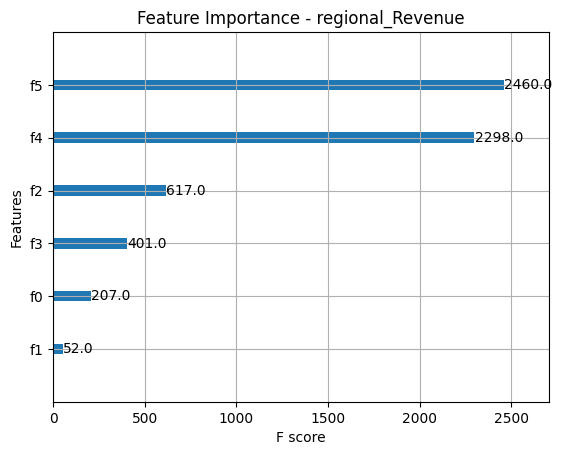

INFO:root:Training regional model for GrossProfit...
INFO:root:R2 Score for GrossProfit: 0.3444
INFO:root:RMSE for GrossProfit: 225.4826
INFO:root:Feature Importance for regional_GrossProfit...


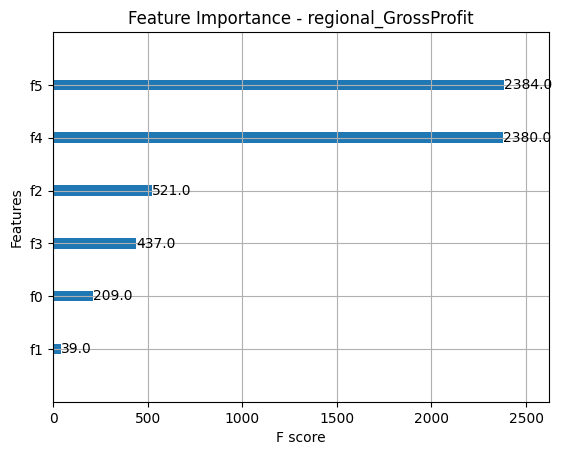

INFO:root:Training regional model for GrossMargin...
INFO:root:R2 Score for GrossMargin: 0.0337
INFO:root:RMSE for GrossMargin: 0.0145
INFO:root:Feature Importance for regional_GrossMargin...


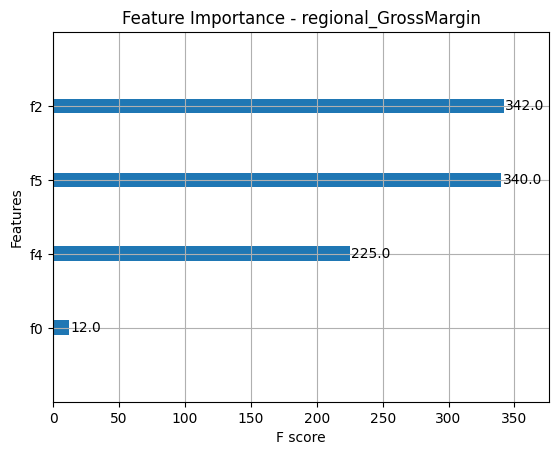

INFO:root:Training regional model for AOV...
INFO:root:R2 Score for AOV: 0.2416
INFO:root:RMSE for AOV: 644.8884
INFO:root:Feature Importance for regional_AOV...


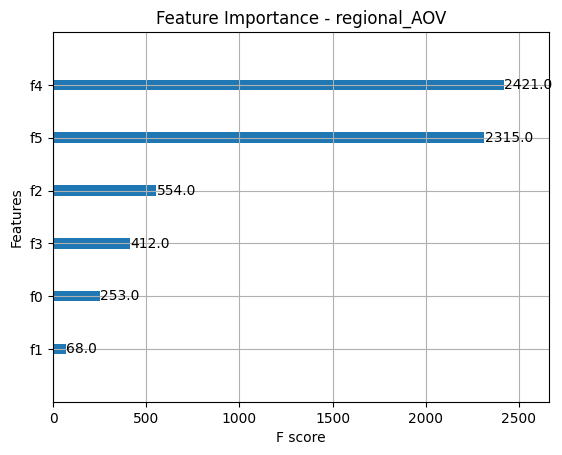

INFO:root:Training regional model for YoYGrowth...
INFO:root:R2 Score for YoYGrowth: -0.0119
INFO:root:RMSE for YoYGrowth: 5.8601
INFO:root:Feature Importance for regional_YoYGrowth...


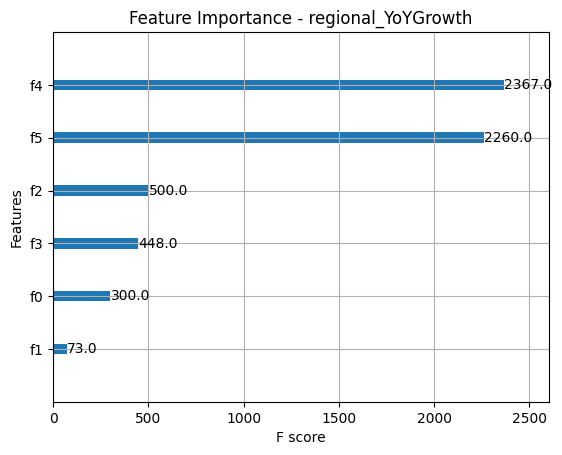

INFO:root:Training temporal model for Revenue...
INFO:root:R2 Score for Revenue: 0.2496
INFO:root:RMSE for Revenue: 973.4709
INFO:root:Feature Importance for temporal_Revenue...


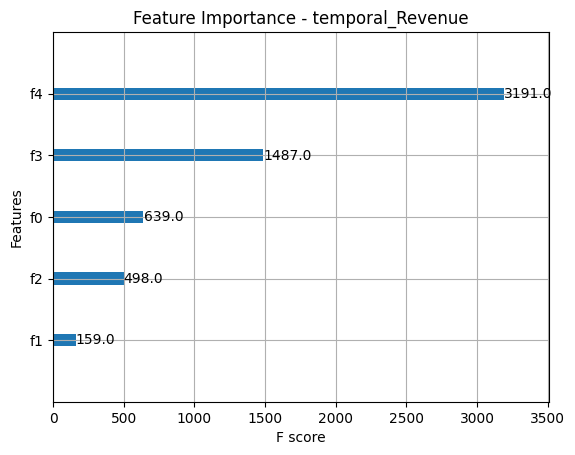

INFO:root:Training temporal model for GrossProfit...
INFO:root:R2 Score for GrossProfit: 0.3599
INFO:root:RMSE for GrossProfit: 222.8097
INFO:root:Feature Importance for temporal_GrossProfit...


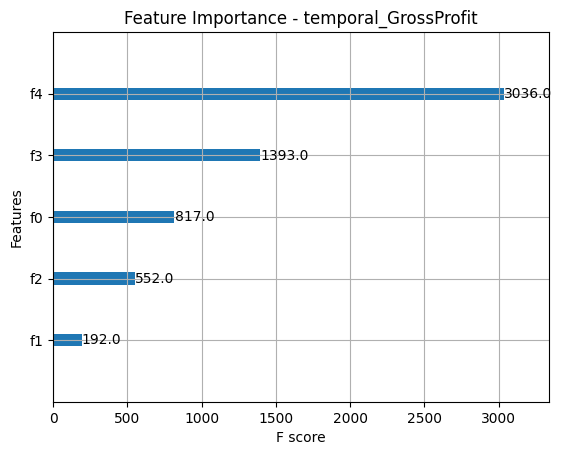

INFO:root:Training temporal model for GrossMargin...
INFO:root:R2 Score for GrossMargin: 0.1606
INFO:root:RMSE for GrossMargin: 0.0135
INFO:root:Feature Importance for temporal_GrossMargin...


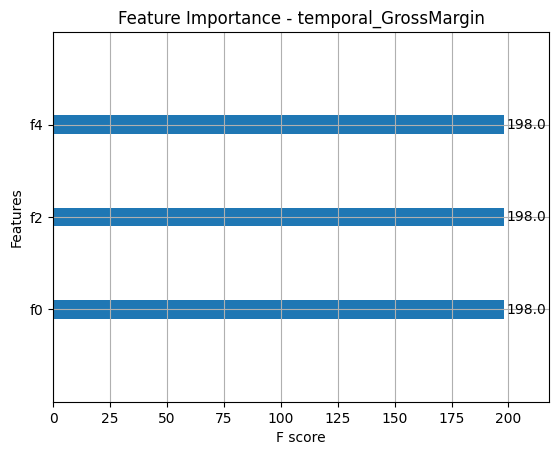

INFO:root:Training temporal model for AOV...
INFO:root:R2 Score for AOV: 0.3395
INFO:root:RMSE for AOV: 601.8207
INFO:root:Feature Importance for temporal_AOV...


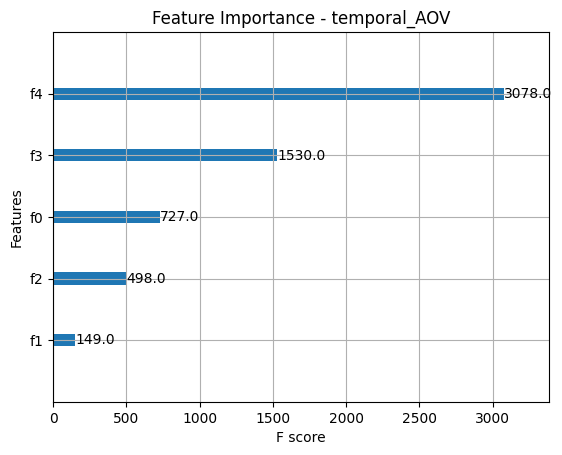

INFO:root:Training temporal model for YoYGrowth...
INFO:root:R2 Score for YoYGrowth: -0.0052
INFO:root:RMSE for YoYGrowth: 5.8406
INFO:root:Feature Importance for temporal_YoYGrowth...


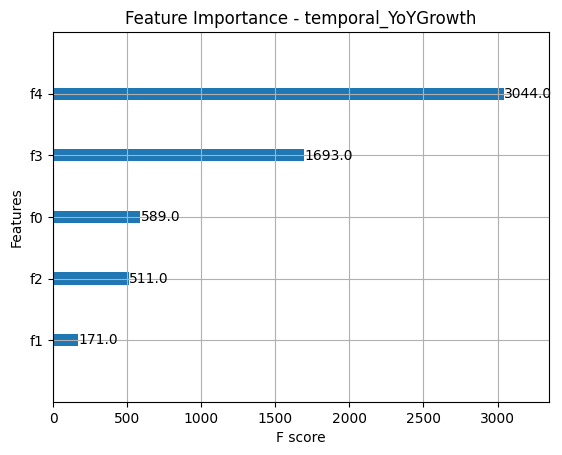

INFO:root:Training product model for Revenue...
INFO:root:R2 Score for Revenue: 0.7436
INFO:root:RMSE for Revenue: 569.0711
INFO:root:Feature Importance for product_Revenue...


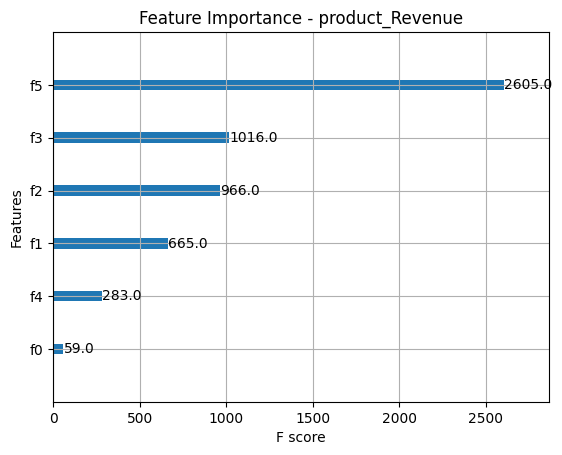

INFO:root:Training product model for GrossProfit...
INFO:root:R2 Score for GrossProfit: 0.5121
INFO:root:RMSE for GrossProfit: 194.5281
INFO:root:Feature Importance for product_GrossProfit...


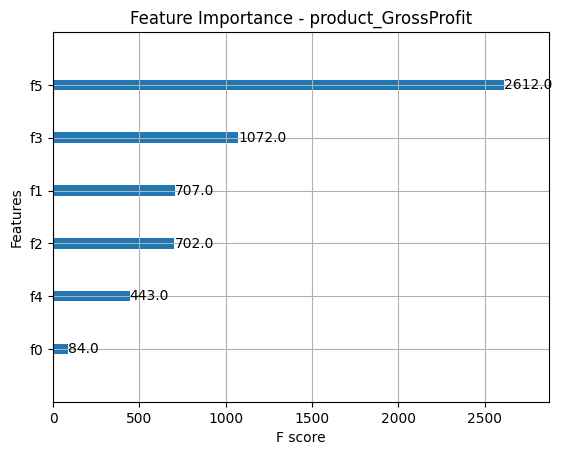

INFO:root:Training product model for GrossMargin...
INFO:root:R2 Score for GrossMargin: 0.0061
INFO:root:RMSE for GrossMargin: 0.0147
INFO:root:Feature Importance for product_GrossMargin...


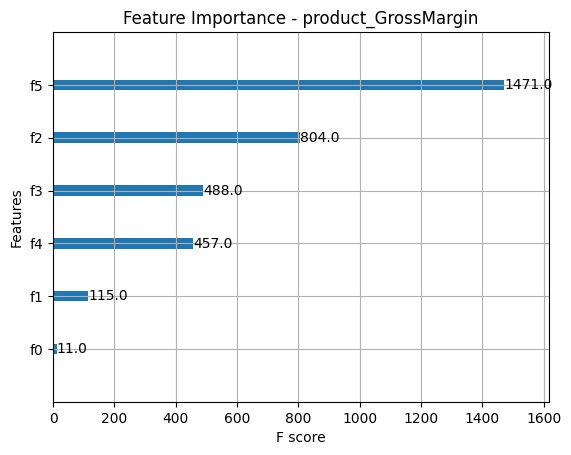

INFO:root:Training product model for AOV...
INFO:root:R2 Score for AOV: 0.9497
INFO:root:RMSE for AOV: 166.0031
INFO:root:Feature Importance for product_AOV...


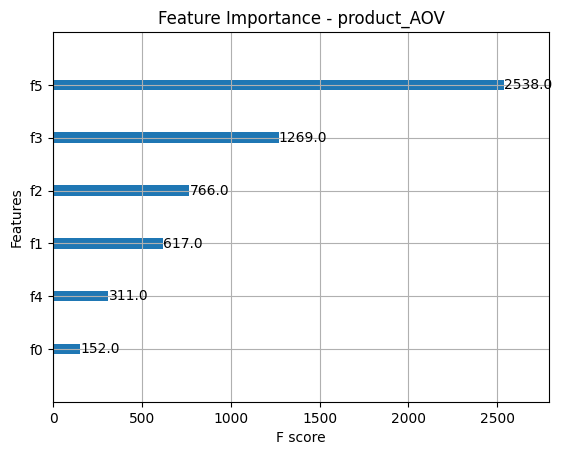

INFO:root:Training product model for YoYGrowth...
INFO:root:R2 Score for YoYGrowth: 0.0880
INFO:root:RMSE for YoYGrowth: 5.5633
INFO:root:Feature Importance for product_YoYGrowth...


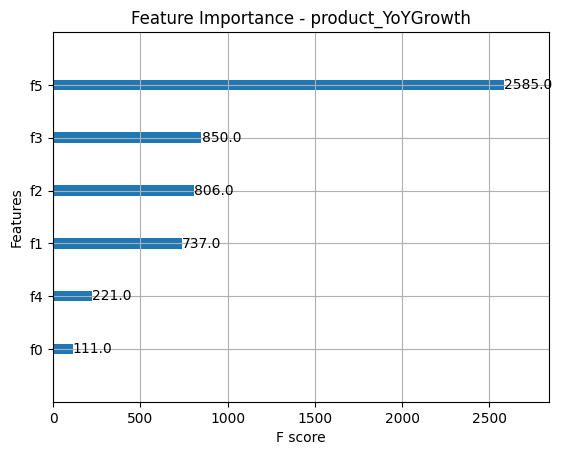

In [3]:
# Example Usage
if __name__ == "__main__":
    # Database Connection Details
    server = "DESKTOP-5N6GTV9"
    database = "CompanyXdwh2"

    # Queries
    fact_sales_query = "SELECT * FROM fact_sales"
    dim_product_query = "SELECT * FROM dim_product"
    dim_date_query = "SELECT * FROM dim_date"
    dim_territory_query = "SELECT * FROM dim_territory"

    # Initialize Class
    prediction = SalesPerformancePrediction()

    # Fetch Data
    fact_sales = prediction.fetch_data_from_sql(fact_sales_query, server, database)
    dim_product = prediction.fetch_data_from_sql(dim_product_query, server, database)
    dim_date = prediction.fetch_data_from_sql(dim_date_query, server, database)
    dim_territory = prediction.fetch_data_from_sql(dim_territory_query, server, database)

    # Prepare Data
    sales_data = prediction.prepare_data(fact_sales, dim_product, dim_date, dim_territory)

    # Train Models
    target_metrics = ['Revenue', 'GrossProfit', 'GrossMargin', 'AOV', 'YoYGrowth']
    prediction.train_regional_models(sales_data, target_metrics)
    prediction.train_temporal_models(sales_data, target_metrics)
    prediction.train_product_models(sales_data, target_metrics)

    # Save Models
    for model_name, model in prediction.models.items():
        joblib.dump(model, f"{model_name}.pkl")